![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [332]:
import warnings
warnings.filterwarnings('ignore')

In [333]:
# Importación de librerías
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [334]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

ESto es la prueba de edición

In [335]:
# Celda 1.1
round(bikes.groupby('season').total.mean(),2)

season
1    116.34
2    215.25
3    234.42
4    198.99
Name: total, dtype: float64

In [336]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

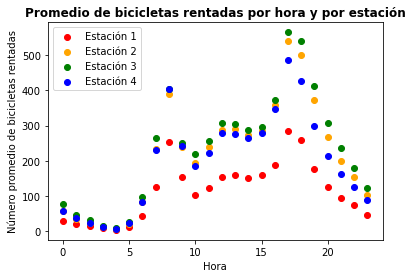

In [337]:
# Calcular el número promedio de bicicletas rentadas por hora y por temporada
hourly_season_avg = bikes.groupby(['season', 'hour'])['total'].mean()
colors = ['red', 'orange', 'green', 'blue']

fig, ax = plt.subplots()
for i, season in enumerate(range(1, 5)):
    season_data = hourly_season_avg.loc[season]
    ax.scatter(season_data.index, season_data.values, color=colors[i], label='Estación '+str(season))

# Configurar la gráfica
ax.set_xlabel('Hora')
ax.set_ylabel('Número promedio de bicicletas rentadas')
ax.set_title('Promedio de bicicletas rentadas por hora y por estación', fontweight = "bold")
ax.legend()
plt.show()


No handles with labels found to put in legend.


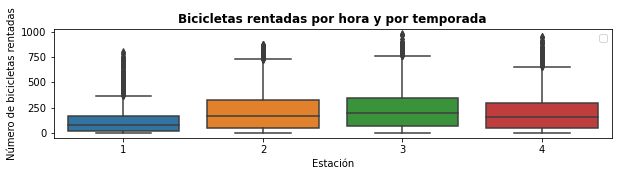

In [338]:
fig = plt.figure(figsize=(10,2))
ax = sns.boxplot(data=bikes, x="season", y='total')

ax.set_xlabel('Estación')
ax.set_ylabel('Número de bicicletas rentadas')
ax.set_title('Bicicletas rentadas por hora y por temporada', fontweight = "bold")
ax.legend()

plt.show()


In [339]:
# Agrupar los datos por temporada y calcular las estadísticas descriptivas
stats = bikes.groupby('season')['total'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


 Se observa en el análisis de las bicicletas rentadas por hora que:
* La desviación de la cnatidad de bicicletas por hora según la estación del año es homogénea en cantidades para todas las estaciones del año.
* Las estaciones 2 y 3 para la renta de las bicicletas tienen los valores promedio más altos, mientras que la Estación  1_Invierno tiene el valor promedio más bajo.
* La mayor variabilidad en los datos, según la desviación estándar se encuentra para la estaciones primavera (2) verano(3).
* Las temporadas 2 y 3 también tienen los valores máximos más altos, con 873 y 977, respectivamente.
* En general, los valores tienden a estar más cerca del tercer cuartil que del primer cuartil, lo que sugiere que hay una tendencia hacia valores más altos en todas las estaciones del año; de acuerdo con los datosanalizados.
* Verano es la estación donde se tiene el valor promedio más alto de bicicletas alquiladas, con un promedio de 234 bicicletas por hora; mientras que en elinvierno la cantidad de biciletas rentados tienen el valor promedio más bajo  con un promedio de 116 bicicletas por día.
* La cantidad de bicicletas alquiladas parece aumentar a medida que avanzan las estaciones del año, con el verano y el otoño se incrementan los valores de bicicletas alquiladas por hora; teniendo los valores máximos más altos de bicicletas alquiladas en estas temporadas.
* La variabilidad en la cantidad de bicicletas alquiladas por hora también parece aumentar a medida que avanzan las estaciones del año , con la temporada 3 y la temporada 4 teniendo las desviaciones estándar más altas.
* En general, la mayoría de las observaciones parecen caer en el rango del segundo y tercer cuartil, lo que sugiere que hay una tendencia hacia alquiler de bicicletas en estaciones del año por hora del día.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

Text(0.5, 1.0, 'Promedio de bicicletas rentadas por hora')

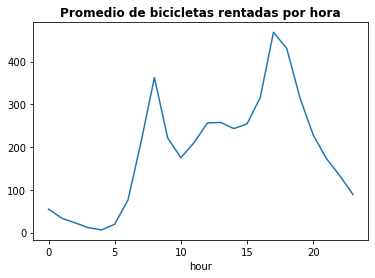

In [340]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()
plt.title('Promedio de bicicletas rentadas por hora', fontweight = "bold")

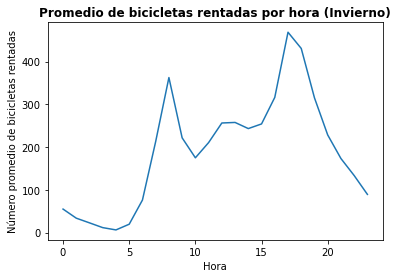

In [341]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
# Filtrar datos para la temporada de invierno
winter_data = bikes[bikes['season'] == 1]

# Calcular el número promedio de bicicletas rentadas por hora
winter_hourly_avg = bikes.groupby('hour').total.mean()

# Crear la gráfica para la temporada de invierno
plt.plot(winter_hourly_avg)
plt.xlabel('Hora')
plt.ylabel('Número promedio de bicicletas rentadas')
plt.title('Promedio de bicicletas rentadas por hora (Invierno)', fontweight = "bold")
plt.show()

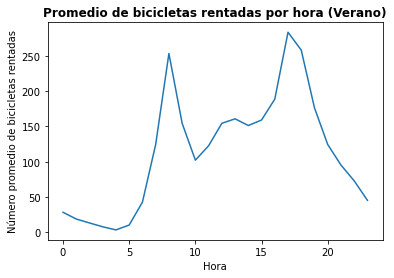

In [342]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# Filtrar datos para la temporada de verano
summer_data = bikes[bikes['season'] == 3]

# Calcular el número promedio de bicicletas rentadas por hora
summer_data_avg = winter_data.groupby('hour').total.mean()

# Crear la gráfica para la temporada de verano
plt.plot(summer_data_avg)
plt.xlabel('Hora')
plt.ylabel('Número promedio de bicicletas rentadas')
plt.title('Promedio de bicicletas rentadas por hora (Verano)', fontweight = "bold")
plt.show()

## Análisis

Se observa que la distribución del alquiler de bicicletas por hora para las estaciones del año de Verano (3) e invierno (1) tienen una distibución similar; sus gráficas representan similutedes en la gráfica presentada.
La distribución para las temporadas miesta que existe jos picos de alquiler dentro de las 24 horas del día; mostrando que el mayor númeroo de biciletas alquildas se realizan entre las 9-10 de la mañana y las 5-6 de la tarde; independiente de la temporada del año en la que se encuentre.
El alquiler de biciletas sufre sus menores cantidades en las horas de la mañana hasta la ocho de la mañana donde se observa se inicia el incremento de alquiler; este comportamiento como se ha indicado no se ve alterado por la temporada del año en la que se encuentre.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [343]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

In [344]:
bikes.shape

(10886, 12)

In [345]:
# Convertir la variable 'season' a una variable dummy
bikes['season']= bikes['season'].astype(str)
season_dummies = pd.get_dummies(bikes['season'])
bikes2 = pd.concat([bikes, season_dummies], axis=1)
bikes2.dtypes


season         object
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
total           int64
hour            int64
1               uint8
2               uint8
3               uint8
4               uint8
dtype: object

In [346]:
# Ajustar el modelo de regresión lineal
X = bikes2[['hour','1','2','3','4']]
y = bikes2['total']
model = LinearRegression().fit(X, y)

# Crear un DataFrame de coeficientes
coef_df = pd.DataFrame({'Variable': ['Intercept','hour','1','2','3','4'], 'Coeficiente': [model.intercept_] + list(model.coef_)})

# Imprimir el DataFrame de coeficientes
print(coef_df)

    Variable  Coeficiente
0  Intercept    69.536712
1       hour    10.545206
2          1   -75.966975
3          2    24.350257
4          3    43.500575
5          4     8.116143


Emplear un modelo de regresión lineal tiene varias limitaciones en este caso. En primer lugar, asume una relación lineal entre las variables predictoras y la variable de respuesta, lo cual puede no ser el caso en la realidad y se debe generar medidas de desempeño del modelo empleado para confirmarlo. 
Además, hay varias variables no incluidas en el modelo que pueden influir en el número de bicicletas rentadas, como la temperatura, la humedad, la velocidad del viento, el día de la semana, entre otras; por lo tanto, el modelo de regresión lineal puede estar subestimando la complejidad del problema y generando resultados inexactos o sesgados; seg{un los predictores selecionados para el análisis.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [347]:
features = range(X.shape[1])
features
feature_cols = X.columns

In [348]:
# Celda 4

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la 
#ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable 
#y punto de cortepara hacer la bifurcación del árbol

def best_split(X, y, num_pct=10):    
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)        
            if gain > best_split[2]:
                best_split = [j, split, gain]    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=None):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']  
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted


In [349]:
# Ejecución de función tree_predict
max_depth = range(1, 6)
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree_predict(X, tree, proba=True)

array([ 25.15934475,  25.15934475,  25.15934475, ..., 152.17996109,
       152.17996109, 152.17996109])

In [350]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_true=bikes2['total']
y_pred=tree_predict(X, tree, proba=True)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("MSE: {:.2f}".format(mse))
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))

MSE: 17393.08
RMSE: 131.88
R2: 0.47
MAE: 91.18


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [351]:
# Celda 5
# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 20)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(round(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean(),4))


Text(0, 0.5, 'Accuracy')

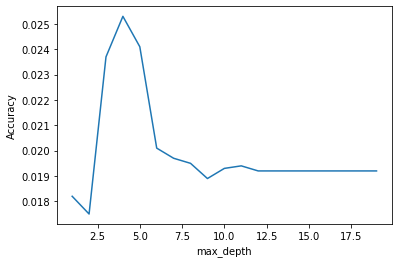

In [352]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [353]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.0253, 4)

In [354]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [355]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,hour,0.793027
1,1,0.196395
4,4,0.010578
2,2,0.000000
3,3,0.000000


In [356]:
y_pred2 = clf.predict(X)
mse2 = mean_squared_error(y_true, y_pred2)
rmse2 = np.sqrt(mse)
r22 = r2_score(y_true, y_pred2)
mae2 = mean_absolute_error(y_true, y_pred2)

print("MSE: {:.2f}".format(mse2))
print("RMSE: {:.2f}".format(rmse2))
print("R2: {:.2f}".format(r22))
print("MAE: {:.2f}".format(mae2))

MSE: 29521.46
RMSE: 131.88
R2: 0.10
MAE: 106.86


In [357]:
# Crear una lista con los nombres de las filas
filas = ['MSE', 'RMSE', 'R2', 'MAE']

# Crear un diccionario con los datos de las columnas
datos = {'Árbol Manual': [mse, rmse,r2, mae],
         'Árbol libreria': [mse2, rmse2,r22, mae2]}

# Crear el DataFrame con los nombres de filas y columnas
tabla = pd.DataFrame(datos, index=filas)

# Imprimir la tabla
tabla

,Árbol Manual,Árbol libreria
MSE,17393.080461,29521.463164
RMSE,131.882829,131.882829
R2,0.469890,0.100238
MAE,91.177553,106.863311


De acuerdo con las medidas de desempeño de los modelos se puede interpretar que el modelo construido manualmente tiene un mejor desempeño en comparación con el modelo construido con la librería. Esto se debe a que el modelo construido manualmente tiene un menor valor de error cuadrático medio (MSE) y un menor error absoluto medio (MAE) en comparación con el modelo construido con la librería.

El valor de RMSE es igual en ambos modelos, lo que indica que ambos modelos tienen un nivel similar de precisión en sus predicciones. Sin embargo, el valor de R2 es mayor en el modelo construido manualmente, lo que indica que este modelo es mejor para explicar la variabilidad en los datos y predecir la cantidad de bicicletas rentadas.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [358]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [359]:
df['Popular']= pd.Categorical(df['Popular'])

In [360]:
df.dtypes

url                               object
timedelta                        float64
n_tokens_title                   float64
n_tokens_content                 float64
n_unique_tokens                  float64
                                  ...   
title_subjectivity               float64
title_sentiment_polarity         float64
abs_title_subjectivity           float64
abs_title_sentiment_polarity     float64
Popular                         category
Length: 61, dtype: object

In [361]:
# Definición variable de interes y variables predictoras
X2 = df.drop(['url', 'Popular'], axis=1)
y2 = df['Popular']
#y.mean()

In [362]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=1)

In [363]:
X_test

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
1483,302.0,9.0,798.0,0.530534,1.0,0.704684,15.0,1.0,4.0,1.0,...,0.370544,0.100000,1.0,-0.385606,-1.000000,-0.050000,0.000000,0.000000,0.500000,0.000000
2185,539.0,6.0,338.0,0.567901,1.0,0.746032,26.0,6.0,0.0,0.0,...,0.479762,0.166667,1.0,-0.633333,-1.000000,-0.300000,0.900000,-0.500000,0.400000,0.500000
2520,408.0,8.0,433.0,0.469880,1.0,0.536797,34.0,5.0,11.0,0.0,...,0.670791,0.100000,1.0,-0.183333,-0.250000,-0.166667,0.433333,-0.166667,0.066667,0.166667
3721,212.0,11.0,309.0,0.579505,1.0,0.671795,24.0,4.0,20.0,1.0,...,0.638889,0.200000,1.0,-0.383333,-0.500000,-0.300000,0.000000,0.000000,0.500000,0.000000
3727,100.0,11.0,430.0,0.551313,1.0,0.734940,12.0,8.0,1.0,1.0,...,0.288604,0.050000,1.0,-0.133333,-0.166667,-0.100000,0.000000,0.000000,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,254.0,10.0,346.0,0.655072,1.0,0.808219,11.0,0.0,1.0,1.0,...,0.348111,0.100000,0.8,-0.155556,-0.250000,-0.083333,0.500000,0.000000,0.000000,0.000000
5166,225.0,10.0,431.0,0.545238,1.0,0.657040,21.0,11.0,1.0,0.0,...,0.353876,0.100000,0.8,-0.255556,-0.400000,-0.166667,0.000000,0.000000,0.500000,0.000000
2227,26.0,16.0,556.0,0.533613,1.0,0.683502,12.0,1.0,1.0,0.0,...,0.429085,0.100000,1.0,-0.300000,-0.700000,-0.100000,0.066667,0.000000,0.433333,0.000000
5684,107.0,13.0,429.0,0.548463,1.0,0.728346,8.0,8.0,1.0,0.0,...,0.289489,0.062500,0.9,-0.333951,-0.800000,-0.050000,0.650000,0.350000,0.150000,0.350000


### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [364]:
# Celda 6
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

#Modelo arbl calibrando profundidad 
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 

# Definición de 4 modelos diferentes: regresión logística, árbol de decisión,Navie Bayes y k vecinos más cercanos
models = {'linear_regression': LinearRegression(),
          'logreg' : LogisticRegression(),
          'tree_decision': DecisionTreeClassifier(max_depth=50, random_state=1)}

# Entrenamiento (fit) de cada modelo
for model in models.keys():
    models[model].fit(X_train, y_train)

# Predicción de las observaciones del set de test para cada modelo
y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    if model=="linear_regression":
        # Predecir las probabilidades de la clase positiva
        y_prob = models[model].predict(X_test)

        # Aplicar un umbral de 0.5 para la predicción binaria
        y_pred[model] = (y_prob > 0.5).astype(int)
    else:
        y_pred[model] = models[model].predict(X_test)
    
# Evaluación del desempeño de cada modelo
for model in models.keys():
    acc = accuracy_score(y_test, y_pred[model])
    f1 = f1_score(y_test, y_pred[model])
    print(f'Modelo "{model}"; Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")')    

Modelo "linear_regression"; Accuracy = 0.6420, F1-Score = 0.6304")
Modelo "logreg"; Accuracy = 0.6140, F1-Score = 0.6101")
Modelo "tree_decision"; Accuracy = 0.5427, F1-Score = 0.5402")


## Análisis
* El modelo Regresión Lineal tiene el mejor desempeño en comparación con los otros dos modelos, ya que tiene la precisión (accuracy) más alta y el puntaje F1-Score más alto. Esto indica que el modelo de regresión lineal es el mejor para predecir el número de bicicletas rentadas, en comparación con los modelos de regresión logística y árbol de decisión.

* El modelo Regresión Logística tiene una precisión y puntaje F1-Score menores que el modelo de regresión lineal, pero todavía tiene una precisión y puntaje F1-Score aceptables. Esto sugiere que el modelo de regresión logística también podría ser útil para predecir el número de bicicletas rentadas, pero con un desempeño un poco más bajo que el modelo de regresión lineal.

* El modelo de árbol de decicisión tiene la precisión y puntaje F1-Score más bajos de los tres modelos. Esto indica que el modelo de árbol de decisión aparentemente no es el más adecuado para predecir el número de bicicletas rentadas, o que se necesitan ajustes o mejoras en el modelo para obtener mejores resultados.

* En general, se recomienda utilizar el modelo de regresión lineal para predecir el número de bicicletas, ya que tiene el mejor desempeño de los tres modelos evaluados.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [365]:
# Creación de 1300 muestras de bootstrap 
np.random.seed(123)

n_samples = df.shape[0]
n_B = 5

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]


In [366]:
df.shape

(6000, 61)

In [367]:
# Celda 7
from sklearn.ensemble import BaggingClassifier, VotingClassifier


#Creación de modelos de acuerdo con las restricciones del problema:
# Crear 100 árboles de decisión con max_depth=5 y 300 muestras bagged
dtree1 = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=42,bootstrap=True)

# Crear 100 árboles de decisión con min_samples_leaf=10 y 300 muestras bagged
dtree2 = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=100, random_state=42)

# Crear 100 regresiones logísticas con regularización L2
logreg = LogisticRegression(penalty='l2', random_state=42, solver='lbfgs', max_iter=1000, n_jobs=-1, verbose=0)

# Crear ensamble de los 3 modelos usando la votación mayoritaria
ensemble = VotingClassifier(estimators=[('dtree1', dtree1), ('dtree2', dtree2), ('logreg', logreg)], voting='hard')

# Entrenar y evaluar cada modelo por separado
models = [dtree1, dtree2, logreg, ensemble]
model_names = ['Decision Tree (max_depth)', 'Decision Tree (min_samples_leaf)', 'Logistic Regression', 'Ensamble']

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model_names[i]}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

# Evaluar el ensamble de modelos
ensemble.fit(X_train, y_train)
y_pred3 = ensemble.predict(X_test)
acce1 = accuracy_score(y_test, y_pred3)
f1e1 = f1_score(y_test, y_pred3)
print(f"\nEnsamble Votación mayoritaria:{model_names} Accuracy = {acce1:.4f}, F1-Score = {f1e1:.4f}")

Decision Tree (max_depth): Accuracy = 0.6573, F1-Score = 0.6573
Decision Tree (min_samples_leaf): Accuracy = 0.6560, F1-Score = 0.6596
Logistic Regression: Accuracy = 0.6180, F1-Score = 0.6029
Ensamble: Accuracy = 0.6547, F1-Score = 0.6537

Ensamble Votación mayoritaria:['Decision Tree (max_depth)', 'Decision Tree (min_samples_leaf)', 'Logistic Regression', 'Ensamble'] Accuracy = 0.6547, F1-Score = 0.6537


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [368]:
# Celda 8
# Crear ensamble de los 3 modelos usando la votación ponderada
weights = [0.3, 0.5, 0.2] # Pesos para los 3 modelos
ensemble2 = VotingClassifier(estimators=[('dtree1', dtree1), ('dtree2', dtree2), ('logreg', logreg)], voting='soft', weights=weights)

# Evaluar el ensamble de modelos
ensemble2.fit(X_train, y_train)
y_pred4 = ensemble2.predict(X_test)
acce2 = accuracy_score(y_test, y_pred4)
f1e2 = f1_score(y_test, y_pred4)
print(f"\nEnsamble Votación Ponderada: Accuracy = {acce2:.4f}, F1-Score = {f1e2:.4f}")


Ensamble Votación Ponderada: Accuracy = 0.6493, F1-Score = 0.6503


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [369]:
# Celda 9

# Crear una lista con los nombres de las filas
filas = ['Accuracy', 'f1_score']

# Crear un diccionario con los datos de las columnas
datos = {'Votación Máxima': [acce1, f1e1],
         'Votación Ponderada': [acce2, f1e2]}

# Crear el DataFrame con los nombres de filas y columnas
tabla2 = pd.DataFrame(datos, index=filas)
tabla2

,Votación Máxima,Votación Ponderada
Accuracy,0.654667,0.649333
f1_score,0.653743,0.650266


## Análisis
* Se observa que al realizar el ensamblaje con Votación mayoritaria o ponderada se mejora el poder de predicción de los modelos en comparación con las métricas obtenidas de forma independiente.
* Los modeleos parecen tener una precisión moderada en la tarea de predecir si una noticia será popular o no, con una precisión de alrededor del 65%. Sin embargo, es importante tener en cuenta que esto puede ser influenciado por el desbalanceo en los datos de entrenamiento. Es decir, si la mayoría de las noticias son populares, el modelo puede tener un sesgo hacia la predicción de que las noticias serán populares; por lo que es importante realizar los análisis para verificar la distribución de los datos con los que se entrenan los modelos.
* El f1_score también es moderado, lo que sugiere que los modeloes tiene un buen equilibrio entre la precisión y la exhaustividad de las predicciones.
* En términos de rendimiento, el modelo de votación máxima parece tener una precisión ligeramente mejor y un f1_score ligeramente más alto que el modelo de votación ponderada. Sin embargo, la diferencia es muy pequeña, por lo que es necesario realizar más pruebas para determinar si esta diferencia es estadísticamente significativa y si es lo suficientemente grande como para justificar el uso de un modelo sobre el otro.